# Estimating functional connectivity on a large dataset

Extracting time series from a functional dataset is long, mainly due to heavy I/O operations. Fortunately, the Preprocessed Connectome Project, initiated by the 1000 Functional Connectomes Project (FCP) and International Neuroimaging Data-sharing Initiative (INDI), provides time-series extracted and pre-processed (filtering, movement regression) for this dataset. The main advantage is that time series are very lightweight.

We use the `fetch_abide_pcp` fetcher and specify that we want the `rois_cc200` derivatives, which correspond to the timeseries extracted for the Craddock 2012 atlas.

In this tutorial, we will learn:
* How to download the ABIDE dataset
* How to estimate a functional connectome
* How to use it to diagnose ASD

In [1]:
from nilearn.datasets.func import fetch_abide_pcp


abide = fetch_abide_pcp(n_subjects=None, quality_checked=True,
                        band_pass_filtering=True, pipeline='cpac',
                        derivatives='rois_cc200')
abide.keys()

dict_keys(['phenotypic', 'rois_cc200', 'description'])

## Connectomes Estimation

Connectivity is typically estimated using *correlation* between time series. Recent studies has shown that *partial correlation* could give better results. Different estimators can also be used to apply some regularization on the matrix coefficients. Nilearn's `ConnectivityMeasure` object (in the `nilearn.connectome` module) provides three types of connectivity matrix: *correlation*, *partial_correlation*, and *tangent* (a method developped in our laboratory). `ConnectivityMeasure` can also use any covariance estimator shipped by scikit-learn (`ShrunkCovariance`, `GraphLasso`).

In a first time, we estimate the connectivity using default parameters. We check that we have one matrix per subject.


In [5]:
from nilearn.connectome import ConnectivityMeasure


conn_est = ConnectivityMeasure(kind='partial correlation')
conn_matrices = conn_est.fit_transform(abide.rois_cc200)
conn_matrices.shape

(871, 200, 200)

## Plotting connectivity matrix

We visualize the connectivity matrix of the first subject. This code is directly taken from a nilearn example.

Text(0.5,1,'Connectivity matrix of subject 0')

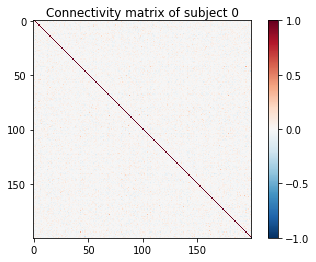

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(conn_matrices[0], vmin=-1., vmax=1., cmap='RdBu_r')
plt.colorbar()
plt.title('Connectivity matrix of subject 0')

## Extracting useful coefficients

Connecitivity matrices are symmetric. As such, half of the coefficients are redundant. They can even impact the results of some predictors. In order to "extract" these coefficients, we want to use a mask. `numpy.tril` function can help us with this task. However, using masking is hazardous without a good knowledge of numpy. Fortunately, nilearn provides a function to do this automatically and efficiently: `nilearn.connectome.sym_to_vec`.

In [8]:
from nilearn.connectome import sym_to_vec


X = sym_to_vec(conn_matrices)
X.shape

(871, 20100)

## Setting up cross-validation

Getting reliable prediction results require to predict on unseen data. Cross-validation consists in leaving out a part of the dataset (testing set) to validate the model learnt on the remaining of the dataset (training set). Scikit-learn has all the utils necessary to do automatic cross-validation. In the case of ABIDE, we have a very heterogenous dataset and we want the sets to be balanced in term of acquisition sites and condition. We use a stratified cross-validation method for that.

In [9]:
from sklearn.cross_validation import StratifiedShuffleSplit


id = [str(sid) + str(dx) for sid, dx in abide.phenotypic[['SITE_ID', 'DX_GROUP']]]
cv = StratifiedShuffleSplit(id, n_iter=10, test_size=.2)

## Prediction using Support Vector Classifier

Now that we have shown how to estimate a connectome and extract the interesting coefficients, we will see how to use them to diagnose ASD vs healthy individuals.

For that purpose, we use a Support Vector Machine. This is one of the most simple classifiers. We use the default parameters in a first time and look at classification scores.

In [10]:
from sklearn.svm import LinearSVC
from sklearn.cross_validation import cross_val_score
import numpy as np


y = abide.phenotypic['DX_GROUP']
predictor = LinearSVC(C=0.01)
np.mean(cross_val_score(predictor, X, y, cv=cv))

0.61896551724137927

In [11]:
predictor

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Exploring other methods and parameters

So far, we built a basic prediction procedure without tuning the parameters. Now we use for loops to explore several options. Note that the imbrication of the steps allow us to re-use connectivity matrix computed in the first loop for the different predictors. The same result can be achieved using nilearn's caching capacities.

In [ ]:
from sklearn.linear_model import RidgeClassifier


measures = ['correlation', 'partial correlation', 'tangent']
predictors = [LinearSVC(C=0.01), LinearSVC(C=0.01, penalty='l1', dual=False), RidgeClassifier()]

for measure in measures:
    conn_est = ConnectivityMeasure(kind=measure)
    conn_matrices = conn_est.fit_transform(abide.rois_cc200)
    X = sym_to_vec(conn_matrices)
    for predictor in predictors:
        print(measure, str(predictor), np.mean(cross_val_score(predictor, X, y, cv=cv)))